In [1]:
import tensorflow as tf
import joblib
import datasets
import numpy as np
import mlflow
import os
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    ViTFeatureExtractor, 
    TFViTForImageClassification,
    create_optimizer
)

from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
)

from dotenv import load_dotenv
load_dotenv()

2025-06-22 01:01:29.179091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 01:01:31.845224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750528892.694196   42109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750528892.894010   42109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-22 01:01:35.547535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

True

In [2]:
tf.__version__, transformers.__version__

('2.18.0', '4.52.4')

# Load Resources

In [3]:
test_ds_path = "../../datasets/CLEAN_NWPU-RESISC45-SAMPLE500-SPLITTED8515/test"

In [4]:
models = {
    "base_vit_p16_in1k": "base_vit_p16_in1k",
    "aug_vit_p16_in1k": "aug_vit_p16_in1k",
}

histories = {    
    "base_vit_p16_in1k": "vit_p16_in1k/history_base_vit_p16_in21k_epoch0015.joblib",
    "aug_vit_p16_in1k": "vit_p16_in1k/history_aug_vit_p16_in21k_epoch0015.joblib",
}

# Load Models
for x in models.keys():
    models[x] = TFViTForImageClassification.from_pretrained(os.path.join("../../outputs/models/", models[x]))
    
# Load Histories
for x in histories.keys():
    histories[x] = joblib.load(os.path.join("../../outputs/histories/", histories[x]))
    
models_obj = list(models.values())
print(models_obj)

I0000 00:00:1750528919.526971   42109 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at ../../outputs/models/base_vit_p16_in1k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at ../../outputs/models/aug_vit_p16_in1k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions witho

[<transformers.models.vit.modeling_tf_vit.TFViTForImageClassification object at 0x7d5be1dfe840>, <transformers.models.vit.modeling_tf_vit.TFViTForImageClassification object at 0x7d5aebfebe30>]


In [5]:
models

{'base_vit_p16_in1k': <transformers.models.vit.modeling_tf_vit.TFViTForImageClassification at 0x7d5be1dfe840>,
 'aug_vit_p16_in1k': <transformers.models.vit.modeling_tf_vit.TFViTForImageClassification at 0x7d5aebfebe30>}

# Preprocess

In [6]:
def create_image_folder_dataset_plain(root_path):
    img_paths = []
    img_labels = []

    for class_name in os.listdir(root_path):
        for fname in os.listdir(os.path.join(root_path, class_name)):
            img_paths.append(os.path.join(root_path, class_name, fname))
            img_labels.append(class_name)

    ds = datasets.Dataset.from_dict({
        "img": img_paths,
        "label": img_labels,
    }, features=datasets.Features({
        "img": datasets.Image(),
        "label": datasets.Value("string"),
    }))

    return ds

def map_labels(example, label2id):
    example["labels"] = int(label2id[example["label"]])
    return example

In [7]:
model_id = "google/vit-base-patch16-224"

num_train_epochs = 15
batch_size = 1
learning_rate = 1e-5
weight_decay_rate = 1e-2
num_warmup_steps = 0

img_size = (224, 224)
batch_size = 10

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

label2id = models[list(models.keys())[0]].config.label2id
id2label = models[list(models.keys())[0]].config.id2label

print("############# CLASSES INFO")
for x in label2id:
    print(f"{label2id[x]}\t{x}")

ds = create_image_folder_dataset_plain(test_ds_path)
ds = ds.map(lambda x: map_labels(x, label2id))
ds = ds.map(lambda x: feature_extractor(x['img'], return_tensors='tf'), batched=True, batch_size=batch_size)

/home/lo0py/.venvs/tf2.18/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


############# CLASSES INFO
0	airplane
11	airport
8	baseball_diamond
39	basketball_court
31	beach
27	bridge
26	chaparral
15	church
16	circular_farmland
1	cloud
6	commercial_area
7	dense_residential
40	desert
42	forest
29	freeway
13	golf_course
35	ground_track_field
36	harbor
25	industrial_area
22	intersection
38	island
20	lake
34	meadow
3	medium_residential
9	mobile_home_park
2	mountain
17	overpass
32	palace
21	parking_lot
18	railway
44	railway_station
37	rectangular_farmland
12	river
14	roundabout
24	runway
30	sea_ice
10	ship
33	snowberg
28	sparse_residential
41	stadium
43	storage_tank
23	tennis_court
5	terrace
4	thermal_power_station
19	wetland


Map: 100%|███████████████████████████████████████████████████████████████████| 3375/3375 [00:50<00:00, 67.10 examples/s]


In [8]:
id2label

{0: 'airplane',
 1: 'cloud',
 10: 'ship',
 11: 'airport',
 12: 'river',
 13: 'golf_course',
 14: 'roundabout',
 15: 'church',
 16: 'circular_farmland',
 17: 'overpass',
 18: 'railway',
 19: 'wetland',
 2: 'mountain',
 20: 'lake',
 21: 'parking_lot',
 22: 'intersection',
 23: 'tennis_court',
 24: 'runway',
 25: 'industrial_area',
 26: 'chaparral',
 27: 'bridge',
 28: 'sparse_residential',
 29: 'freeway',
 3: 'medium_residential',
 30: 'sea_ice',
 31: 'beach',
 32: 'palace',
 33: 'snowberg',
 34: 'meadow',
 35: 'ground_track_field',
 36: 'harbor',
 37: 'rectangular_farmland',
 38: 'island',
 39: 'basketball_court',
 4: 'thermal_power_station',
 40: 'desert',
 41: 'stadium',
 42: 'forest',
 43: 'storage_tank',
 44: 'railway_station',
 5: 'terrace',
 6: 'commercial_area',
 7: 'dense_residential',
 8: 'baseball_diamond',
 9: 'mobile_home_park'}

In [9]:
test_ds = ds.to_tf_dataset(
   columns=["pixel_values"],
   label_cols=["labels"],
   shuffle=False,
   batch_size=batch_size)

classes = list(label2id.keys())

/home/lo0py/.venvs/tf2.18/lib/python3.12/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [10]:
num_train_steps = len(test_ds) * num_train_epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
) 

for x in models_obj:
    x.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

# Evaulation

## Loss and Acc

In [11]:
def model_eval(model, name):
    loss, acc = model[name].evaluate(test_ds, verbose=0)
    print(f"### eval result of {name} ####\nTest Loss: {loss}\nTest Acc: {acc}")
    return loss, acc

In [12]:
loss_base_vit_p16_1nk, acc_base_vit_p16_1nk = model_eval(models, "base_vit_p16_in1k")
loss_aug_vit_p16_1nk, acc_aug_vit_p16_1nk = model_eval(models, "aug_vit_p16_in1k")

I0000 00:00:1750528987.538412   42352 cuda_dnn.cc:529] Loaded cuDNN version 90300


### eval result of base_vit_p16_in1k ####
Test Loss: 0.26264500617980957
Test Acc: 0.9508148431777954
### eval result of aug_vit_p16_in1k ####
Test Loss: 0.25466638803482056
Test Acc: 0.9484444260597229


## Predictions

In [13]:
y_true = np.concatenate([label.numpy() for _, label in test_ds])
len(y_true)

2025-06-22 01:04:25.321191: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3375

In [14]:
## Base VIT
output_base_vit_p16_in1k_preds = models["base_vit_p16_in1k"].predict(test_ds)
logits_base_vit_p16_in1k_preds = output_base_vit_p16_in1k_preds.logits
base_vit_p16_in1k_preds = tf.nn.softmax(logits_base_vit_p16_in1k_preds, axis=-1)
base_vit_p16_in1k_preds_labels = np.argmax(base_vit_p16_in1k_preds, axis=-1)

## AUG VIT
output_aug_vit_p16_in1k_preds = models["aug_vit_p16_in1k"].predict(test_ds)
logits_aug_vit_p16_in1k_preds = output_aug_vit_p16_in1k_preds.logits
aug_vit_p16_in1k_preds = tf.nn.softmax(logits_aug_vit_p16_in1k_preds, axis=-1)
aug_vit_p16_in1k_preds_labels = np.argmax(aug_vit_p16_in1k_preds, axis=-1) 

338/338 [==============================] - 33s 91ms/step


## Classification Report

In [15]:
base_vit_p16_in1k_clfreport = classification_report(base_vit_p16_in1k_preds_labels, y_true, target_names=classes, output_dict=True)
aug_vit_p16_in1k_clfreport = classification_report(aug_vit_p16_in1k_preds_labels, y_true, target_names=classes, output_dict=True)

## Confussion Matrix Each Model

In [16]:
def plot_cm(y_pred, y_true, model_name):
    plt.figure(figsize=(15, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.title(f'Confusion Matrix of {model_name} Performance')
    plt.show()

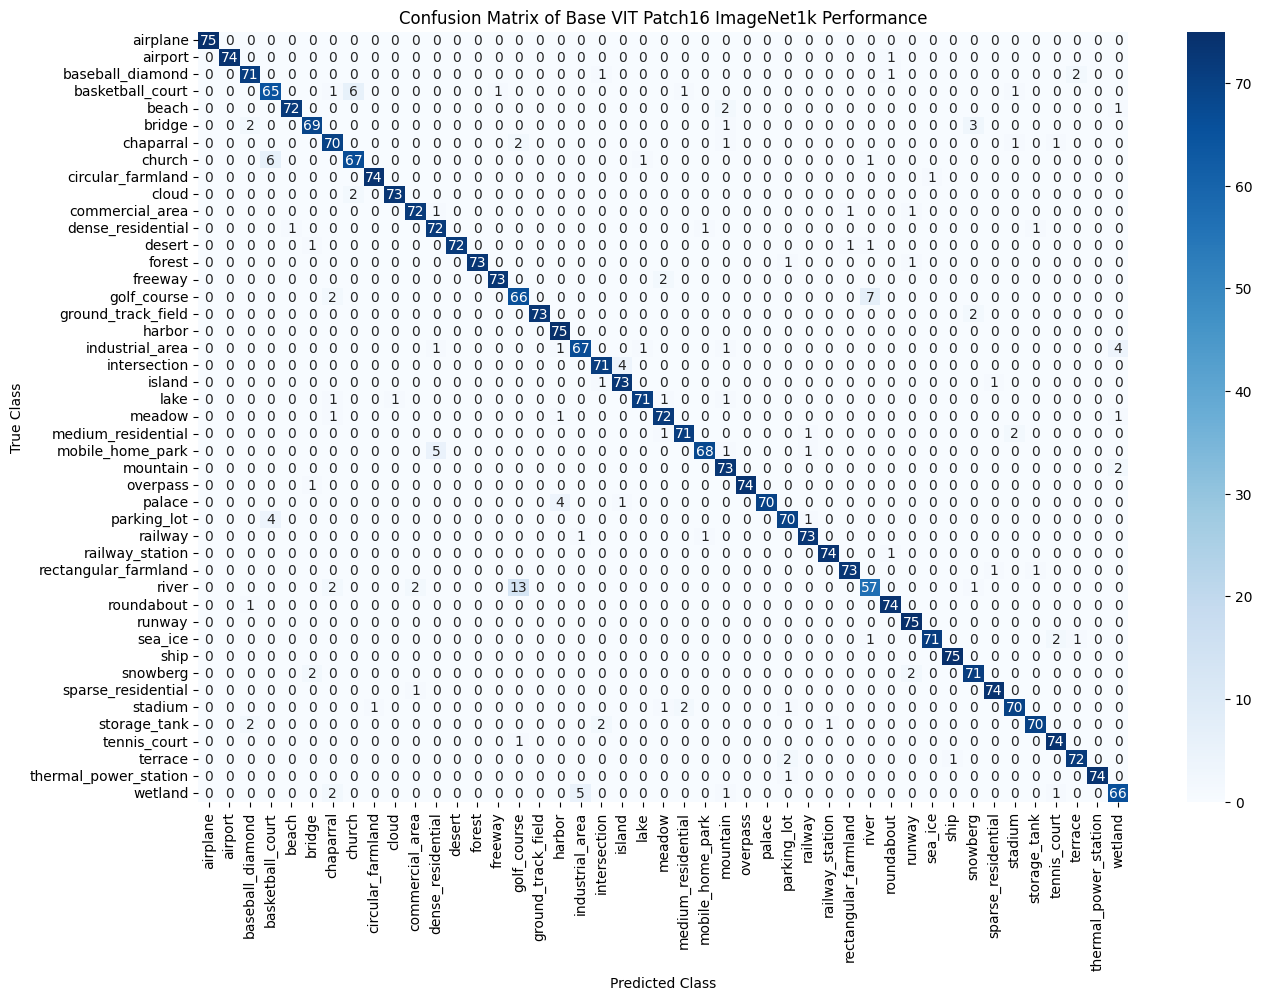

In [17]:
plot_cm(base_vit_p16_in1k_preds_labels, y_true, "Base VIT Patch16 ImageNet1k")

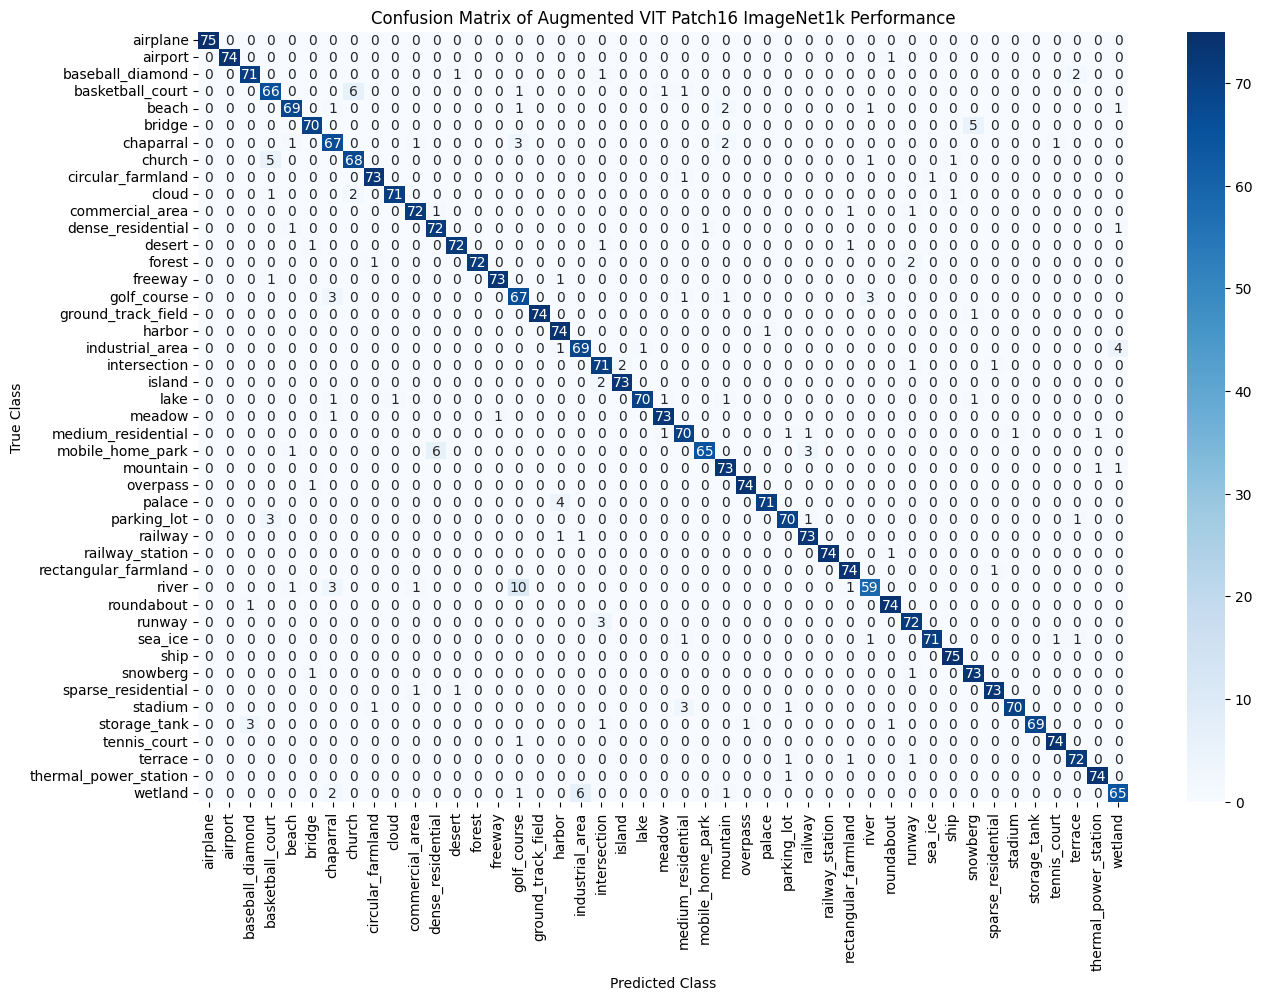

In [18]:
plot_cm(aug_vit_p16_in1k_preds_labels, y_true, "Augmented VIT Patch16 ImageNet1k")

# Deploy to MLFlow Tracking

In [19]:
models

{'base_vit_p16_in1k': <transformers.models.vit.modeling_tf_vit.TFViTForImageClassification at 0x7d5be1dfe840>,
 'aug_vit_p16_in1k': <transformers.models.vit.modeling_tf_vit.TFViTForImageClassification at 0x7d5aebfebe30>}

In [20]:
model_acc = [acc_base_vit_p16_1nk, acc_aug_vit_p16_1nk]
model_clfreport = [base_vit_p16_in1k_clfreport, aug_vit_p16_in1k_clfreport]

model_acc_f = {
    name: model_acc[i] for i, name in enumerate(models.keys())
}

model_clfreport_f = {
    name: model_clfreport[i] for i, name in enumerate(models.keys())
}

In [21]:
X_test = []
y_test = []

for x, y in test_ds.take(1):
    X_test.append(x.numpy())
    y_test.append(y.numpy())
        
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

len(X_test), len(y_test)

2025-06-22 01:05:34.338106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(10, 10)

In [22]:
histories_f = {
    list(models.keys())[i]: val for i, val in enumerate(histories.values())
}

In [23]:
os.getenv("EXPERIMENT_NAME")

'RSSC'

In [24]:
mlflow.set_tracking_uri(os.getenv("MLFOW_TRACKING_SERVER_URL"))
mlflow.set_experiment(os.getenv("EXPERIMENT_NAME"))

for model_name in models:
    with mlflow.start_run(run_name=f"log_{model_name}"):
        
        # ========= TRAINING HISTORY
        epochs=15
        for i, acc in enumerate(histories_f[model_name]["accuracy"]):
            mlflow.log_metric("train_accuracy", acc, step=i)
        
        for i, val_acc in enumerate(histories_f[model_name]["val_accuracy"]):
            mlflow.log_metric("train_val_accuracy", val_acc, step=i)
        
        
        # ========= LOG ACCURACY
        mlflow.log_metric("accuracy", model_acc_f[model_name])
        
        
        # ========= MODEL SIGNATURE        
        outputs = models["base_vit_p16_in1k"].predict(X_test)
        logits = outputs.logits
        y_preds_prob = tf.nn.softmax(logits, axis=-1)
        y_pred = np.argmax(y_preds_prob, axis=-1)
        
        
        X_test_sample = X_test[:1]
        if isinstance(X_test_sample, tf.Tensor):
            X_test_sample = X_test_sample.numpy()
        
        y_pred_sample = y_preds_prob[:1]
        if isinstance(y_pred_sample, tf.Tensor):
            y_pred_sample = y_pred_sample.numpy()
        
        signature = mlflow.models.signature.infer_signature(X_test_sample, y_pred_sample)
        
        
        # ========= AVG N MACRO
        for avg_type in ["macro avg", "weighted avg"]:
            for metric_name, val in model_clfreport_f[model_name][avg_type].items():
                if metric_name != "support":
                    mlflow.log_metric(
                        f"{avg_type.replace(' ', '_')}_{metric_name}", 
                        val
                    )
        
                    
        # ========= Metrics perClass
        for class_name in classes:
            metrics = model_clfreport_f[model_name][class_name]
            for metric_name, value in metrics.items():
                if metric_name != "support":
                    mlflow.log_metric(
                        f"class_{class_name}_{metric_name}", 
                        value
                    )
                
                    
        # ========= MODEL ARTIFACT
        mlflow.tensorflow.log_model(
            models[model_name],
            artifact_path="model",
            signature=signature,
            registered_model_name=f"{model_name}_rssc"
        )

        
        print(f"Logged MLflow Run for: {model_name}")

2025/06/22 01:05:37 INFO mlflow.tracking.fluent: Experiment with name 'RSSC' does not exist. Creating a new experiment.


1/1 [==============================] - 3s 3s/step
INFO:tensorflow:Assets written to: /tmp/tmprq6u4zhg/model/tf2model/assets


INFO:tensorflow:Assets written to: /tmp/tmprq6u4zhg/model/tf2model/assets
2025/06/22 01:12:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmprq6u4zhg/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'base_vit_p16_in1k_rssc'.
2025/06/22 01:15:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: base_vit_p16_in1k_rssc, version 1
Created version '1' of model 'base_vit_p16_in1k_rssc'.


Logged MLflow Run for: base_vit_p16_in1k
🏃 View run log_base_vit_p16_in1k at: https://rssc-model-tracker-h0h9eme5g7facdgz.southeastasia-01.azurewebsites.net/#/experiments/1/runs/5b9db85872e7486eba8e5e992dc69a88
🧪 View experiment at: https://rssc-model-tracker-h0h9eme5g7facdgz.southeastasia-01.azurewebsites.net/#/experiments/1
1/1 [==============================] - 1s 686ms/step
INFO:tensorflow:Assets written to: /tmp/tmpjtl3m0a4/model/tf2model/assets


INFO:tensorflow:Assets written to: /tmp/tmpjtl3m0a4/model/tf2model/assets
2025/06/22 01:22:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpjtl3m0a4/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'aug_vit_p16_in1k_rssc'.
2025/06/22 01:24:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aug_vit_p16_in1k_rssc, version 1
Created version '1' of model 'aug_vit_p16_in1k_rssc'.


Logged MLflow Run for: aug_vit_p16_in1k
🏃 View run log_aug_vit_p16_in1k at: https://rssc-model-tracker-h0h9eme5g7facdgz.southeastasia-01.azurewebsites.net/#/experiments/1/runs/c7223dcd417c45c4b8d0c7074bd8a7ac
🧪 View experiment at: https://rssc-model-tracker-h0h9eme5g7facdgz.southeastasia-01.azurewebsites.net/#/experiments/1
